In [1]:
import geopandas as gpd
import pandas as pd
import map_apis
map_apis.RADIUS = 750 # Define the radius of the search

In [2]:
# Get neighborhoods geometry
gdf = gpd.read_file('../../database/neighborhoods.gpkg')

# Get API Coordinates
api_coords = pd.read_csv('grids/grid_centroids.csv')
centroids = api_coords[['api_lat', 'api_lon']].drop_duplicates(keep='first')

## Get venues with APIs

In [ ]:
# Tags
tags ={
    'parks':{'leisure': 'park'},
    'schools': {'amenity': ['school', 'university', 'kindergarten', 'college']},
    'public_transport': {
        'highway': 'bus_stop',
        'public_transport': 'station',
        'name': ['Macrobús', 'MiBici'],
        'railway': 'station',
        'station': 'light_rail',
        'amenity': 'bicycle_rental',
    }
}
venue_type = 'parks'  # 'parks' | 'schools' | 'public_transport'

osm_df = map_apis.get_osm_venues(gdf, tags=venue_type)
osm_df.to_file(f'../../database/venues_gpkg/{venue_type}.gpkg', driver="GPKG", index=False)

100%|██████████| 1008/1008 [07:58<00:00,  2.11it/s]


In [ ]:
categ_codes = {
    'retail': ['17000'],  # Retail
    'health': ['15000'],  # Health and medicine
    'education': ['12009'],  # Community and Government > Education
}
categs = 'retail'  # 'retail' | 'health' | 'education'
fsq_df = map_apis.get_fsq_venues(categories=categs, centroids=centroids)
fsq_df.to_csv(f'{categs}_venues.txt', sep='\t', index=False)

grids: 100%|██████████| 546/546 [2:15:15<00:00, 14.86s/it]  


## Map Plots

In [10]:
# Import
venue_type = 'parks'  # 'parks' | 'schools' | 'public_transport'
gdf_venues = gpd.read_file(f'../../database/venues_gpkg/{venue_type}.gpkg')

categs = 'retail'  # 'retail' | 'health' | 'education'
df_venues = pd.read_csv(f'{categs}_venues.txt', sep='\t')

In [25]:
# Filter
gdf_layer = gdf_venues
df_layer = df_venues[df_venues['name'].str.lower().str.contains('farmacias guadalajara')]

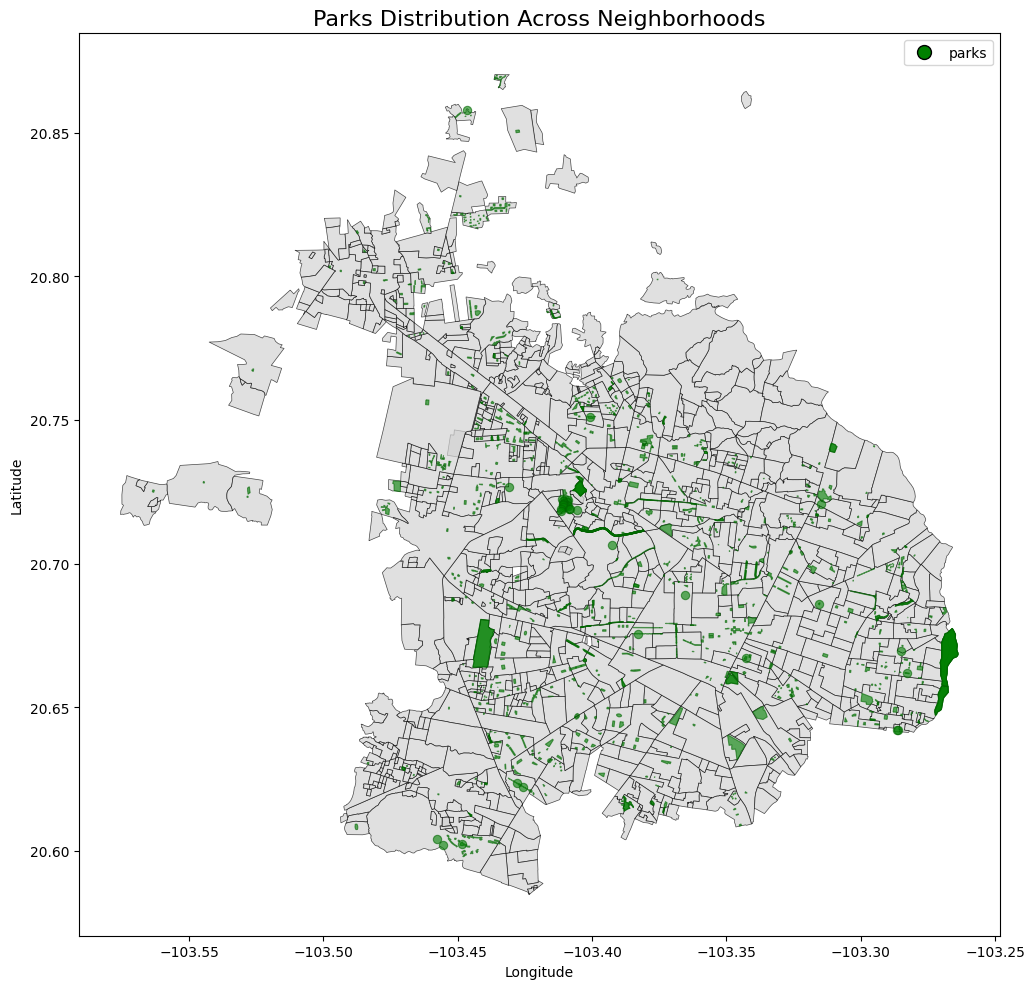

In [12]:
map_apis.plot_gdf_over_gdf(
    gdf_base=gdf,
    gdf_layer=gdf_layer,
    title='Parks Distribution Across Neighborhoods',
    legend_label='parks',
    save=False,
    layer_color='green',
    layer_edgecolor='darkgreen'
    )

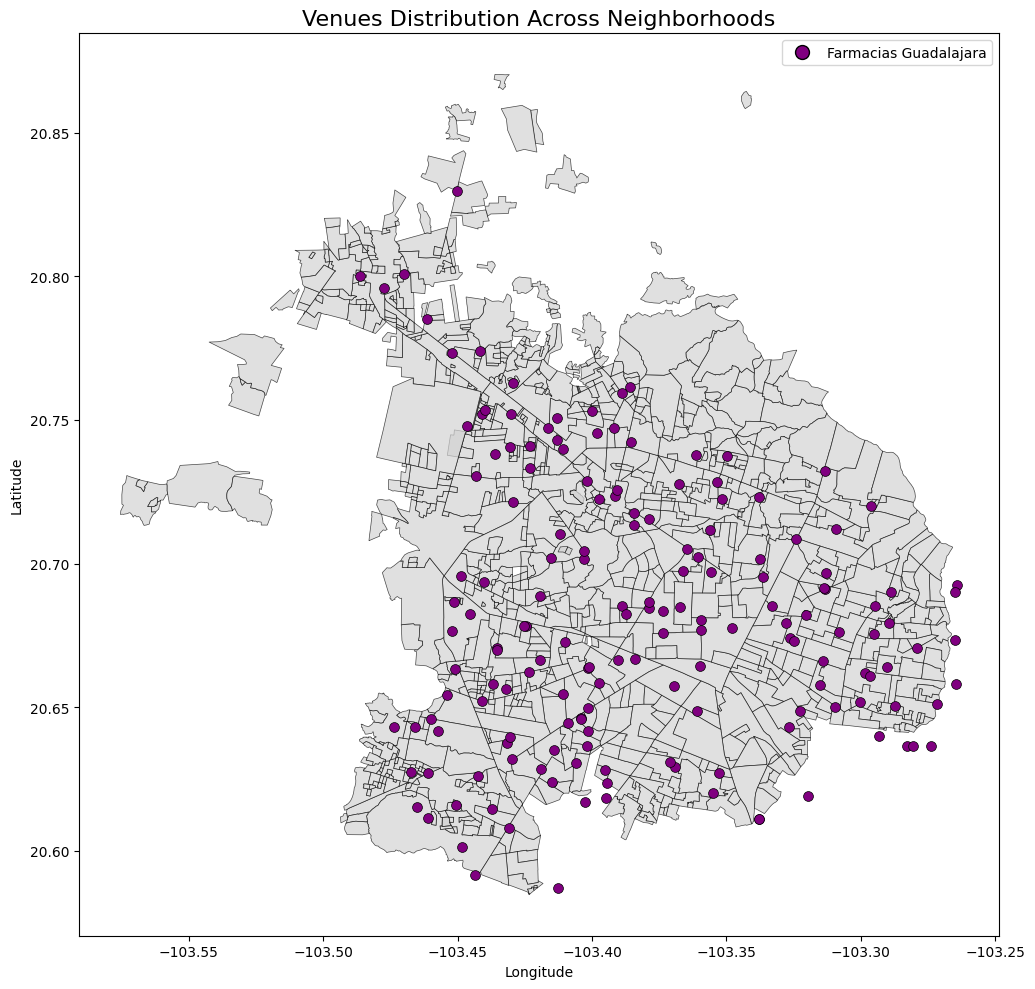

In [31]:
map_apis.plot_df_over_gdf(
    gdf_base=gdf,
    df_layer=df_layer,
    title='Farmacias Guadalajara in Guadalajara and Zapopan',
    legend_label='Farmacias Guadalajara',
    save=False,
    layer_color='purple',
    layer_edgecolor='black'
)

In [8]:
import folium
import folium.plugins

venue_to_look = 'hospital'
curr_ven = fsq_df[fsq_df['category'].str.lower().str.contains(venue_to_look)]
center_lat, center_lon = curr_ven['lat'].mean(), curr_ven['lon'].mean()
# Convert venue DataFrame to GeoDataFrame
gdf_venues = gpd.GeoDataFrame(
    curr_ven,
    geometry=gpd.points_from_xy(curr_ven.lon, curr_ven.lat),
    crs="EPSG:4326"  # WGS84 coordinate reference system
)

m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles='cartodbpositron')

# Add neighborhoods as polygons with tooltips
folium.GeoJson(
    gdf,
    name='neighborhood',
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': '#000000',
        'weight': 1,
        'fillOpacity': 0.2
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['neighborhood'],  # adjust to your neighborhood attribute fields
        aliases=['neighborhood: '],
        localize=True
    )
).add_to(m)

# Add venues as markers with clustering
marker_cluster = folium.plugins.MarkerCluster().add_to(m)

for idx, row in gdf_venues.iterrows():
    popup_text = f"<b>{row['name']}</b><br>Category: {row['category']}"
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=popup_text,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# Add layer control to toggle layers
folium.LayerControl().add_to(m)

# Display the map
m.save('./ex.html')